In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()  #

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [4]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["8b80aa05d88b518b"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [8]:
EXPERIMENT_NAME = "urban_driver_pdm_closed_cross"

scenario_types = [
    "starting_left_turn",
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    # "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    "scenario_filter.num_scenarios_per_type=15",  # use 10 scenarios per scenario type #bring this back to 25 for testing the cross bug
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]

In [9]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        "model=urban_driver_open_loop_model",
        "planner.ml_planner.model_config=${model}",
        f"planner.ml_planner.checkpoint_path={urban_ckpt}",
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",  # 0.1
        "+occlusion_cfg.notice_threshold=1.0",  # 0.1
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=true",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+modifier_types=[cross-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')


# planner: pdm_closed
##########################################
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
##########################################

# obs: pdm_closed
##########################################
# f"observation.planner_type=pdm_closed",
##########################################

# planner: urban driver
##########################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=urban_driver_open_loop_model",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={urban_ckpt}",
##########################################

# obs: urban driver
##########################################
# "+observation.model=urban_driver_open_loop_model",
# f"observation.planner_type=ml",
# "+observation.model_config=${model}",
# f"observation.checkpoint_path={urban_ckpt}",
##########################################

# planner: gc_pgp
################################################
# "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# "model=gc_pgp_model",
# "model.aggregator.pre_train=false",
# "planner.ml_planner.model_config=${model}",
# f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
###############################################

# obs: gc_pgp
###############################################
# "+observation.model_config=${model}",
# "+observation.model=gc_pgp_model",
# "+observation.model.aggregator.pre_train=false",
# f"observation.planner_type=ml",
# f"observation.checkpoint_path={gc_pgp_ckpt}",
################################################


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,

default_simulation


output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.07.05.54"


# Now we can run with the following

In [10]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-04-18 07:05:55,028 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-18 07:05:55,065 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-18 07:05:56,821	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-18 07:05:57,519 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-18 07:05:57,520 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-18 07:05:57,520 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-18 07:05:57,520 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-18 07:05:57,520 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.07.05.54

2024-04-18 07:05:57,522 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
(raylet) [2024-04-18 07:06:06,805 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605506347008; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 07:06:08,859 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-18 07:06:08,992 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-18 07:06:08,992 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 115 scenarios...
2024-04-18 07:06:08,995 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:09,022 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:09,413 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:09,436 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:

(raylet) [2024-04-18 07:06:16,808 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605504835584; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 07:06:17,117 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:17,141 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:17,453 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:17,478 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:17,600 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:17,624 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:17,943 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 07:06:26,813 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605502906368; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 07:06:27,187 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:27,212 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:27,521 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:27,546 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:27,875 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:27,899 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:28,023 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 07:06:36,818 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605500973056; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 07:06:36,926 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:36,951 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:37,278 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:37,302 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:37,431 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 07:06:37,455 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 07:06:37,821 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 07:06:46,824 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605498941440; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 07:06:56,866 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605494534144; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 07:07:06,930 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605494497280; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:  97%|█████████▋| 111/115 [02:02<00:23,  5.87s/it](raylet) [2024-04-18 07:09:17,202 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_

2024-04-18 07:13:05,081 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 8 modified scenarios from scenario with token: 04f3724b7de95996.


100%|██████████| 8/8 [00:00<00:00, 206.28it/s]
0it [00:00, ?it/s]

2024-04-18 07:13:05,123 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 1 modified scenarios from scenario with token: 052512c630e8582d.


100%|██████████| 1/1 [00:00<00:00, 182.38it/s]
0it [00:00, ?it/s]

2024-04-18 07:13:05,132 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 67 modified scenarios from scenario with token: 1258fa27af6c5108.


100%|██████████| 67/67 [00:00<00:00, 199.81it/s]
10it [00:00, 25.66it/s]

2024-04-18 07:13:05,471 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 16 modified scenarios from scenario with token: 164802e4d77753a3.


100%|██████████| 16/16 [00:00<00:00, 55.94it/s]
13it [00:00, 17.79it/s]

2024-04-18 07:13:05,760 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 1 modified scenarios from scenario with token: 1a63987839cb5589.


100%|██████████| 1/1 [00:00<00:00, 186.57it/s]
13it [00:00, 17.79it/s]

2024-04-18 07:13:05,768 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 5 modified scenarios from scenario with token: 1fe7ecfc356254b8.


100%|██████████| 5/5 [00:00<00:00, 188.26it/s]
13it [00:00, 17.79it/s]

2024-04-18 07:13:05,798 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 14 modified scenarios from scenario with token: 202722a1a31d5f3d.


100%|██████████| 14/14 [00:00<00:00, 202.14it/s]
17it [00:00, 21.76it/s]

2024-04-18 07:13:05,873 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 11 modified scenarios from scenario with token: 2525c75e178f5146.


100%|██████████| 11/11 [00:00<00:00, 130.18it/s]
17it [00:00, 21.76it/s]

2024-04-18 07:13:05,961 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 13 modified scenarios from scenario with token: 267ea35c58805705.


100%|██████████| 13/13 [00:00<00:00, 191.95it/s]
21it [00:00, 22.71it/s]

2024-04-18 07:13:06,033 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 40 modified scenarios from scenario with token: 2b9543b2672c5103.


100%|██████████| 40/40 [00:00<00:00, 194.47it/s]
24it [00:01, 19.63it/s]

2024-04-18 07:13:06,243 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 15 modified scenarios from scenario with token: 2cf5cc182a6b521d.


100%|██████████| 15/15 [00:00<00:00, 152.99it/s]
24it [00:01, 19.63it/s]

2024-04-18 07:13:06,344 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 97 modified scenarios from scenario with token: 2ef90003b27b5e13.


100%|██████████| 97/97 [00:00<00:00, 168.10it/s]
27it [00:01, 10.02it/s]

2024-04-18 07:13:06,925 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 20 modified scenarios from scenario with token: 3e01db99e214566b.


100%|██████████| 20/20 [00:00<00:00, 181.19it/s]
33it [00:01, 15.57it/s]

2024-04-18 07:13:07,041 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 1 modified scenarios from scenario with token: 3ee495098deb5816.


100%|██████████| 1/1 [00:00<00:00, 173.32it/s]
33it [00:01, 15.57it/s]

2024-04-18 07:13:07,049 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 17 modified scenarios from scenario with token: 4197fbbd54a95c24.


100%|██████████| 17/17 [00:00<00:00, 187.95it/s]
36it [00:02, 17.55it/s]

2024-04-18 07:13:07,143 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 14 modified scenarios from scenario with token: 4acaf7e4c6ff567f.


100%|██████████| 14/14 [00:00<00:00, 172.01it/s]
36it [00:02, 17.55it/s]

2024-04-18 07:13:07,231 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 10 modified scenarios from scenario with token: 4c60b3da01fa5c14.


(raylet) [2024-04-18 07:13:07,318 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605431345152; capacity: 16125711347712. Object creation will fail if spilling is required.
100%|██████████| 10/10 [00:00<00:00, 33.24it/s]
40it [00:02, 14.30it/s]

2024-04-18 07:13:07,536 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 13 modified scenarios from scenario with token: 4e42b3a5d51953d0.


100%|██████████| 13/13 [00:00<00:00, 194.89it/s]
40it [00:02, 14.30it/s]

2024-04-18 07:13:07,607 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 2 modified scenarios from scenario with token: 5359ebb4202d5671.


100%|██████████| 2/2 [00:00<00:00, 70.05it/s]
40it [00:02, 14.30it/s]

2024-04-18 07:13:07,639 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 2 modified scenarios from scenario with token: 535da17365015b40.


100%|██████████| 2/2 [00:00<00:00, 192.16it/s]
43it [00:02, 16.08it/s]

2024-04-18 07:13:07,653 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 34 modified scenarios from scenario with token: 5bf602b113005389.


100%|██████████| 34/34 [00:00<00:00, 164.19it/s]
46it [00:02, 15.55it/s]

2024-04-18 07:13:07,864 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 7 modified scenarios from scenario with token: 5f8328cffcc250f2.


100%|██████████| 7/7 [00:00<00:00, 195.53it/s]
46it [00:02, 15.55it/s]

2024-04-18 07:13:07,903 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 12 modified scenarios from scenario with token: 78085da6ae0e5615.


100%|██████████| 12/12 [00:00<00:00, 195.39it/s]
58it [00:02, 32.40it/s]

2024-04-18 07:13:07,969 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 12 modified scenarios from scenario with token: 7c4f406ae1365585.


100%|██████████| 12/12 [00:00<00:00, 204.36it/s]
58it [00:02, 32.40it/s]

2024-04-18 07:13:08,031 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 5 modified scenarios from scenario with token: 7d28ead3acdf5157.


100%|██████████| 5/5 [00:00<00:00, 201.85it/s]
58it [00:02, 32.40it/s]

2024-04-18 07:13:08,059 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 4 modified scenarios from scenario with token: 81912b4cd7c15f57.


100%|██████████| 4/4 [00:00<00:00, 190.80it/s]
63it [00:03, 34.72it/s]

2024-04-18 07:13:08,084 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 14 modified scenarios from scenario with token: 831e5d0d49195825.


100%|██████████| 14/14 [00:00<00:00, 197.93it/s]
63it [00:03, 34.72it/s]

2024-04-18 07:13:08,158 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 8 modified scenarios from scenario with token: 8a1f98f89e825c6e.


100%|██████████| 8/8 [00:00<00:00, 203.15it/s]
69it [00:03, 38.57it/s]

2024-04-18 07:13:08,201 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 30 modified scenarios from scenario with token: 8f7978c3c5075a28.


100%|██████████| 30/30 [00:00<00:00, 194.92it/s]
69it [00:03, 38.57it/s]

2024-04-18 07:13:08,359 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 2 modified scenarios from scenario with token: a18bd749b8da5d28.


100%|██████████| 2/2 [00:00<00:00, 177.44it/s]
74it [00:03, 35.40it/s]

2024-04-18 07:13:08,374 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 8 modified scenarios from scenario with token: a1c624f373555774.


100%|██████████| 8/8 [00:00<00:00, 135.08it/s]
74it [00:03, 35.40it/s]

2024-04-18 07:13:08,436 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 28 modified scenarios from scenario with token: a268bc5234b55040.


100%|██████████| 28/28 [00:00<00:00, 155.04it/s]
74it [00:03, 35.40it/s]

2024-04-18 07:13:08,620 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 3 modified scenarios from scenario with token: a725b8e5751956a7.


100%|██████████| 3/3 [00:00<00:00, 187.49it/s]
74it [00:03, 35.40it/s]

2024-04-18 07:13:08,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 18 modified scenarios from scenario with token: a7d56f9491895b69.


100%|██████████| 18/18 [00:00<00:00, 139.38it/s]
79it [00:03, 23.45it/s]

2024-04-18 07:13:08,773 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 30 modified scenarios from scenario with token: b775f395ffb15d44.


100%|██████████| 30/30 [00:00<00:00, 174.58it/s]
85it [00:03, 26.13it/s]

2024-04-18 07:13:08,948 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 4 modified scenarios from scenario with token: bd5605fe07d65993.


100%|██████████| 4/4 [00:00<00:00, 185.51it/s]
85it [00:03, 26.13it/s]

2024-04-18 07:13:08,972 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 95 modified scenarios from scenario with token: ccf23a9288075b08.


100%|██████████| 95/95 [00:00<00:00, 98.77it/s]
90it [00:04, 12.10it/s]

2024-04-18 07:13:09,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 12 modified scenarios from scenario with token: cdb7c17bfeb05a3b.


100%|██████████| 12/12 [00:00<00:00, 180.60it/s]
90it [00:04, 12.10it/s]

2024-04-18 07:13:10,007 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 11 modified scenarios from scenario with token: cef8317f71b3525e.


100%|██████████| 11/11 [00:00<00:00, 136.30it/s]
93it [00:05, 13.06it/s]

2024-04-18 07:13:10,091 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 30 modified scenarios from scenario with token: d66ddbec7ff958a1.


100%|██████████| 30/30 [00:00<00:00, 149.74it/s]
96it [00:05, 13.39it/s]

2024-04-18 07:13:10,294 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 15 modified scenarios from scenario with token: da34f29c3b155a86.


100%|██████████| 15/15 [00:00<00:00, 176.19it/s]
96it [00:05, 13.39it/s]

2024-04-18 07:13:10,382 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 21 modified scenarios from scenario with token: dd23fafc53f45abe.


100%|██████████| 21/21 [00:00<00:00, 183.83it/s]
102it [00:05, 16.87it/s]

2024-04-18 07:13:10,499 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 22 modified scenarios from scenario with token: e0447a52b4ec5b45.


100%|██████████| 22/22 [00:00<00:00, 177.03it/s]
105it [00:05, 17.97it/s]

2024-04-18 07:13:10,627 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:187}  Created 27 modified scenarios from scenario with token: f2274fb56dd653c5.


100%|██████████| 27/27 [00:00<00:00, 163.96it/s]
115it [00:05, 20.13it/s]


2024-04-18 07:13:10,844 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:206}  Created 819 modified scenarios from 115 scenarios, 44 of which were modifiable.
2024-04-18 07:13:10,845 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:207}  Building simulations...DONE!
2024-04-18 07:13:10,845 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-04-18 07:13:10,845 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-04-18 07:13:10,846 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 819 simulations using RayDistributed!


(raylet) [2024-04-18 07:13:17,331 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605429506048; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 07:13:27,411 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605428744192; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 07:13:37,474 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 605428318208; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:   0%|          | 0/819 [00:00<?, ?it/s](raylet) [2024-04-18 07:13:47,495 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is

2024-04-18 08:10:46,457 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 819
2024-04-18 08:10:46,463 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-18 08:10:46,463 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-18 08:10:46,651 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.07.05.54/runner_report.parquet
2024-04-18 08:10:46,652 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 01:04:51 [HH:MM:SS]


(raylet) [2024-04-18 08:10:50,522 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 594317770752; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 08:10:58,049 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:11 [HH:MM:SS]
2024-04-18 08:10:58,318 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_aggregator_callback.py:58}  Running metric aggregator: closed_loop_multiagent_weighted_average
2024-04-18 08:10:59,160 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_aggregator_callback.py:69}  Metric aggregator: 00:00:00 [HH:MM:SS]
2024-04-18 08:10:59,365 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:00 [HH:MM:SS]
2024-04-18 08:10:59,368 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:115}  Finished running simulation!


# Now we set up the second running regime

In [11]:
#########################################

path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print(f"+scenarios_to_check={scenario_list}")

hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)
cfg_unocc = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=ml_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        "model=urban_driver_open_loop_model",
        "planner.ml_planner.model_config=${model}",
        f"planner.ml_planner.checkpoint_path={urban_ckpt}",
        ################################################
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=false",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=false",
        ################################################
        # scenario modification
        ################################################
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+scenarios_to_check={scenario_list}",
        "+modifier_types=[cross-conflict-with-occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right,
        # oncoming-left-turn-and-occlusion-injection, conflict-and-occlusion-injection,
        # sequential-conflict-with-occlusion-injection, cross-conflict-with-occlusion-injection
        # merge-conflict-with-occlusion-injection, diverge-conflict-with-occlusion-injection]
        "+remove_other_agents=true",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ###############################################
    ],
)

output_folder_unocc = cfg_unocc.output_dir
print('output_folder_unocc = "' + output_folder_unocc + '"')

+scenarios_to_check=['a18bd749b8da5d28_cross_conflict_injection_and_occlusion_injection_0_0.0_52804', 'd66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_2_-0.8_70137', 'f2274fb56dd653c5_cross_conflict_injection_and_occlusion_injection_0_0.0_47826', 'da34f29c3b155a86_cross_conflict_injection_and_occlusion_injection_0_0.0_20117', 'cdb7c17bfeb05a3b_cross_conflict_injection_and_occlusion_injection_3_0.0_20330', 'f2274fb56dd653c5_cross_conflict_injection_and_occlusion_injection_1_0.0_47826', '2ef90003b27b5e13_cross_conflict_injection_and_occlusion_injection_6_-5.0_69312', 'da34f29c3b155a86_cross_conflict_injection_and_occlusion_injection_5_5.0_20109', 'd66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_70137', 'e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_70137', 'e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_68702', '3e01db99e214566b_cross_conflict_injection_and_occlusion_injection_4_5.0_70137', 'cdb

(raylet) [2024-04-18 08:11:00,527 E 3321033 3321045] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_07-05-55_143612_3320611 is over 95% full, available space: 594326814720; capacity: 16125711347712. Object creation will fail if spilling is required.


output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.08.11.01"


## Run Second Regime

In [12]:
main_simulation(cfg_unocc)

Global seed set to 0


2024-04-18 08:11:01,871 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2024-04-18 08:11:01,893 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2024-04-18 08:11:02,066 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-04-18 08:11:02,067 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2024-04-18 08:11:05,808 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-04-18 08:11:09,921	INFO worker.py:1636 -- Started a local Ray instance.


2024-04-18 08:11:10,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-04-18 08:11:10,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-04-18 08:11:10,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-04-18 08:11:10,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-04-18 08:11:10,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.08.11.01

2024-04-18 08:11:10,642 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


2024-04-18 08:11:22,172 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-04-18 08:11:22,300 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-04-18 08:11:22,300 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 115 scenarios...
2024-04-18 08:11:22,302 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:22,323 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:22,441 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:22,468 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:

(raylet) [2024-04-18 08:11:29,426 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594320318464; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 08:11:29,540 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:29,568 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:29,685 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:29,713 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:30,083 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:30,109 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:30,225 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 08:11:39,431 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594314768384; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 08:11:39,818 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:39,845 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:39,960 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:39,985 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:40,356 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:40,382 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:40,724 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 08:11:49,438 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594301841408; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 08:11:49,896 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:49,923 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:50,040 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:50,066 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:50,463 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2024-04-18 08:11:50,484 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2024-04-18 08:11:50,834 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building

(raylet) [2024-04-18 08:11:59,444 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594314706944; capacity: 16125711347712. Object creation will fail if spilling is required.
Ray objects:   0%|          | 0/221 [00:00<?, ?it/s](raylet) [2024-04-18 08:12:09,460 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594314133504; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 08:12:19,503 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 594313342976; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 08:12:29,561 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is

2024-04-18 08:25:04,873 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 221
2024-04-18 08:25:04,873 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-04-18 08:25:04,874 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-04-18 08:25:04,927 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.08.11.01/runner_report.parquet
2024-04-18 08:25:04,927 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:14:03 [HH:MM:SS]
2024-04-18 08:25:07,856 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:02 [HH:MM:SS]
2024-04-18 08:25:07,963

In [13]:
import pandas as pd
import re
import pickle

path_unocc = output_folder_unocc + "/metrics/"
file_path_2 = path_unocc + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_2)
df = df.loc[
    df["number_of_ego_collisions_with_vehicles_stat_value"] == 0
]  # we know all these scenarios are ones where we crahsed in the occluded regime, so here, we are selecting all the ones where we also didnt crash in the unoccluded regime
df = df["scenario_name"]
scenario_list = df.tolist()
print(f"scenario mods to save to npsc file={scenario_list}")
base_scenario_tokens = [re.split("_", name, 1)[0] for name in scenario_list]
print(f"base scenarios={base_scenario_tokens}")

modification_list_dictionary = {}
with open(r"modifications_for_second_testing_round.pkl", "rb") as input_file:
    modifications_for_second_testing_round = pickle.load(input_file)

    for token in base_scenario_tokens:
        modification_list_dictionary[token] = []

    print("number of generated OCC's", len(scenario_list))

    for full_modification_token in scenario_list:
        base_token = re.split("_", full_modification_token, 1)[0]
        for modification_object in modifications_for_second_testing_round[base_token]:
            if (
                base_token + modification_object.modifier_string
                == full_modification_token
            ):
                modification_list_dictionary[base_token].append(modification_object)
                print(base_token + modification_object.modifier_string)
                break


with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "wb") as output_file:
    pickle.dump(modification_list_dictionary, output_file)
    pickle.dump(DATASET_PARAMS, output_file)

with open("npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl", "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(mod_list_dict.keys())
    data = pickle.load(output_file)
    print(data)

print(EXPERIMENT_NAME)

scenario mods to save to npsc file=['d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_2_-0.8_70137', 'da34f29c3b155a86_cross_conflict_injection_and_occlusion_injection_0_0.0_20117', 'd66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_70137', 'e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_70137', 'e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_68702', '3e01db99e214566b_cross_conflict_injection_and_occlusion_injection_4_5.0_70137', '831e5d0d49195825_cross_conflict_injection_and_occlusion_injection_3_5.0_20010', '4acaf7e4c6ff567f_cross_conflict_injection_and_occlusion_injection_1_5.0_70137', 'd66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_68702', 'e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_3_-1.0_70137', '3e01db99e214566b_cross_conflict_injection_and_occlusion_injection_1_5.0_68702', 'd66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_1_

number of generated OCC's 83
d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_2_-0.8_70137
da34f29c3b155a86_cross_conflict_injection_and_occlusion_injection_0_0.0_20117
d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_70137
e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_70137
e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_68702
3e01db99e214566b_cross_conflict_injection_and_occlusion_injection_4_5.0_70137
831e5d0d49195825_cross_conflict_injection_and_occlusion_injection_3_5.0_20010
4acaf7e4c6ff567f_cross_conflict_injection_and_occlusion_injection_1_5.0_70137
d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_68702
e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_3_-1.0_70137
3e01db99e214566b_cross_conflict_injection_and_occlusion_injection_1_5.0_68702
d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_1_-0.8_70137
e0447a52b4ec5b45_cross_conflic

number_of_ego_collisions_with_vehicles_stat_value (top 25 differences)
positive diff
                                                                     scenario_name  difference                                         scenario_type_1
1   d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_2_-0.8_70137           1                         starting_unprotected_cross_turn
3    da34f29c3b155a86_cross_conflict_injection_and_occlusion_injection_0_0.0_20117           1                                      starting_left_turn
8   d66ddbec7ff958a1_cross_conflict_injection_and_occlusion_injection_3_-0.8_70137           1                         starting_unprotected_cross_turn
9    e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_70137           1                         starting_unprotected_cross_turn
10   e0447a52b4ec5b45_cross_conflict_injection_and_occlusion_injection_2_0.0_68702           1                         starting_unprotected_cross_turn
11   3e01

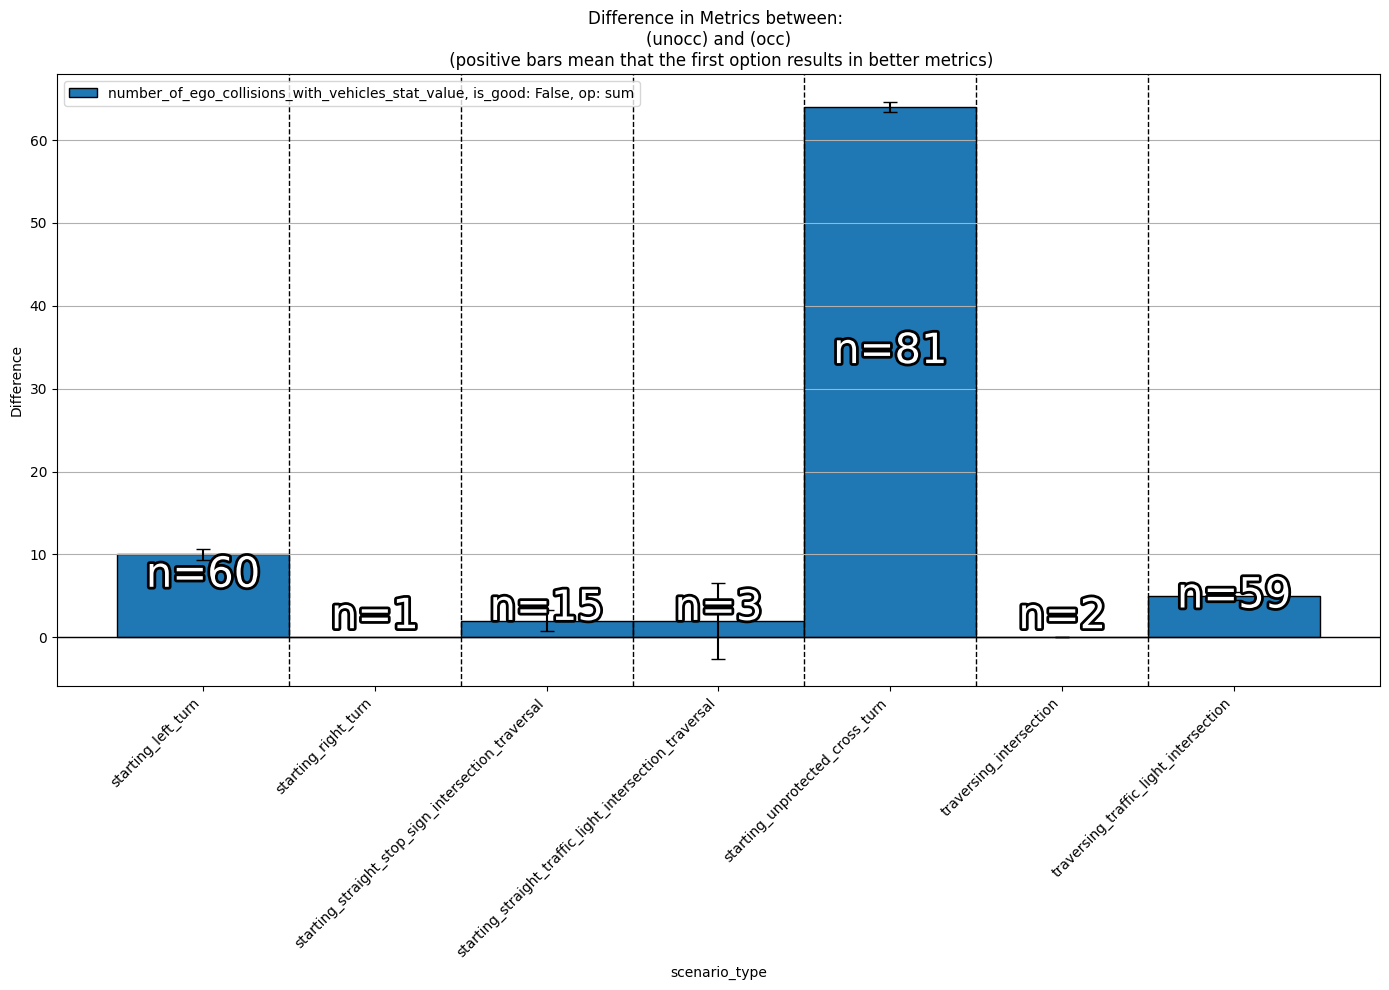

In [14]:
from vis_utils import plot_diff

# %env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
# %env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
# %env NUPLAN_EXP_ROOT=../../data/nuplan/exp
# %env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
# %pwd

# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.41.02"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.56.48"
# )

file_path_1 = output_folder_unocc + "/metrics/" + "no_ego_at_fault_collisions.parquet"
file_path_2 = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"


metrics = [
    "number_of_ego_collisions_with_vehicles_stat_value",
]
metric_op = [
    "sum",
]
# metrics are 'good' if you would like to succeed at them. ex: amount of crashes is bad, amount of money is good
good_metric = [
    False,
]

plot_diff(
    file_path_1,
    file_path_2,
    "unocc",
    "occ",
    metrics,
    metric_op,
    good_metric,
    group_by="scenario_type",
    k_differences=25,
    as_bool=True,
)

## Prepare the nuBoard config

In [15]:
# import hydra

# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.06.45"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.02.28.20.55.22"
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.19.32.17"
# )
# output_folder_unocc = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.03.05.20.12.11"
# )
# output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.15.30"
# output_folder_unocc = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.10.04.21.15"

# output_folder_unocc = '../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.02.00.15.36'
output_folder = [output_folder_occ, output_folder_unocc]
# output_folder_occ = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.05.04.32.36"
# )
# output_folder = [output_folder_occ]
print(output_folder_occ)
print(output_folder_unocc)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.07.05.54
../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.18.08.11.01


## Launch nuBoard (open in new tab - recommended)


In [16]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-04-18 08:25:09,235 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-04-18 08:25:09,253 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-04-18 08:25:09,254 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-04-18 08:25:09,254 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-04-18 08:25:09,254 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-04-18 08:25:09,255 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 746.97ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.59ms


2024-04-18 08:25:11,748 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.59ms
2024-04-18 08:25:11,749 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-04-18 08:25:11,749 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


(raylet) [2024-04-18 08:25:12,439 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 591375941632; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-04-18 08:25:12,473 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-04-18 08:25:12,733 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0065 seconds.
2024-04-18 08:25:12,828 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 710.74ms


INFO:tornado.access:200 GET / (127.0.0.1) 710.74ms
(raylet) [2024-04-18 08:25:22,443 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 591373914112; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 08:25:32,446 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 591365980160; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 08:25:42,450 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is over 95% full, available space: 591369654272; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-04-18 08:25:52,453 E 3363313 3363325] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-18_08-11-05_849922_3320611 is 